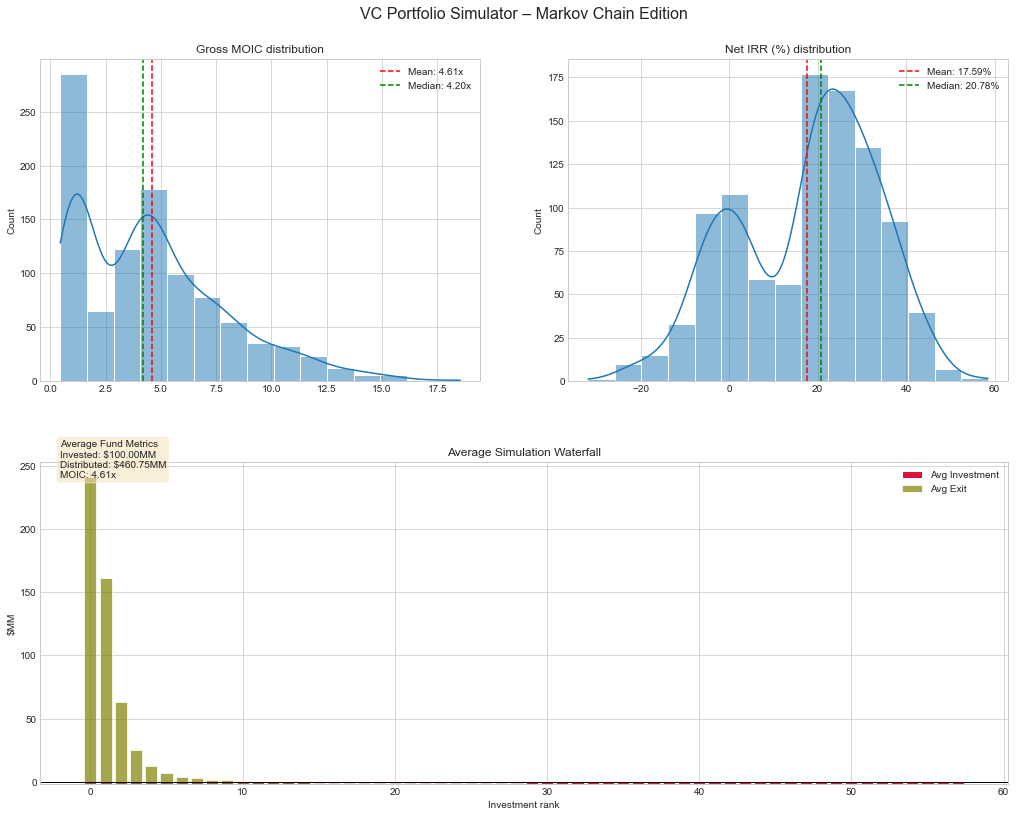


--------------  Simulation Summary  --------------
          Metric   Mean  Median
   Paid-in [$MM] 100.00  100.00
 Mgmt fees [$MM]  20.00   20.00
    Called [$MM] 120.00  120.00
Gross dist [$MM] 460.75  419.67
  Net dist [$MM] 440.75  399.67
  Gross MOIC [×]   4.61    4.20
    Net MOIC [×]   4.41    4.00
     Net DPI [×]   3.67    3.33
     Net IRR [%]  17.59   20.78
   # Investments  57.62   58.00


In [15]:
# %%  VC Markov-chain portfolio simulator  (single Jupyter cell)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf

plt.style.use('seaborn-v0_8-whitegrid')

# ───────────────────────────────────────────────────────────
# 1) USER CONFIGURATION
# ───────────────────────────────────────────────────────────
# Stage allocations - percentage of deployable capital allocated to each stage
# These are easy to adjust - simply modify these values
stage_allocations = {
    'Pre-Seed': 50,
    'Seed': 50,
    'Series A': 0,
    'Series B': 0
}

cfg = dict(
    stage_allocations=stage_allocations,  # Using the variable defined above

    valuations={  # $MM post-money entry valuation range
        'Pre-Seed': (3, 6), 'Seed': (8, 15),
        'Series A': (40, 80), 'Series B': (100, 150)},

    check_sizes={  # $MM cheque size range
        'Pre-Seed': (1.0, 1.5), 'Seed': (1.5, 2.0),
        'Series A': (5.0, 10.0), 'Series B': (5, 10)},

    # one-step advancement probabilities (to next round)
    prob_advancement={
        'Pre-Seed': 0.50, 'Seed': 0.33,
        'Series A': 0.48, 'Series B': 0.43,
        'Series C': 0.28},

    # one-step failure probabilities (absorbing loss)
    zero_probabilities={
        'Pre-Seed': 0.30, 'Seed': 0.30,
        'Series A': 0.30, 'Series B': 0.20,
        'Series C': 0.20, 'IPO': 0.00},

    # years between successful rounds
    years_to_next={
        'Pre-Seed': (1, 2), 'Seed': (1, 3),
        'Series A': (1, 3), 'Series B': (1, 3),
        'Series C': (1, 1)},  # fixed 1-yr to IPO

    # % ownership dilution on each finance
    dilution={
        'Pre-Seed': (10, 25), 'Seed': (10, 25),
        'Series A': (10, 25), 'Series B': (10, 15),
        'Series C': (10, 15)},

    # exit valuation ranges ($MM) if cashed-out from that stage
    exit_valuations={
        'Pre-Seed': (4, 10), 'Seed': (5, 10),
        'Series A': (20, 40), 'Series B': (40, 120),
        'Series C': (200, 500), 'IPO': (3000, 5000)}
)

# ───────────────────────────────────────────────────────────
# 2) FUND PARAMETERS
# ───────────────────────────────────────────────────────────
fund_size = 100  # $MM committed
initial_stage = 'Seed'
stages = ['Pre-Seed', 'Seed', 'Series A', 'Series B']
management_fee_pct = 2.0  # % per year
management_fee_years = 10
deployment_years = 3
num_simulations = 1000
rng_seed = None

# ───────────────────────────────────────────────────────────
# 3) DERIVED CONSTANTS & HELPERS
# ───────────────────────────────────────────────────────────
rng = np.random.default_rng(rng_seed)
stage_index = stages.index(initial_stage)
valid_stages = stages[stage_index:]
alloc_total = sum(cfg['stage_allocations'][s] for s in valid_stages) or 1
stage_alloc = {s: cfg['stage_allocations'][s] / alloc_total * 100
               for s in valid_stages}
deployable_capital = fund_size

full_chain = ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C', 'IPO', 'Fail']

# Build a transition-probability lookup (row-stochastic matrix form)
transition = {}
for i, s in enumerate(full_chain):
    if s in ('IPO', 'Fail'):  # absorbing
        transition[s] = {'IPO': 1.0} if s == 'IPO' else {'Fail': 1.0}
    else:
        adv = cfg['prob_advancement'][s]
        fail = cfg['zero_probabilities'][s]
        stay = 1 - adv - fail  # early exit (cash-out) prob.
        nxt = full_chain[i + 1]
        transition[s] = {nxt: adv, 'Exit': stay, 'Fail': fail}


def rand_in(lo_hi): lo, hi = lo_hi; return rng.uniform(lo, hi) if lo != hi else lo


# ───────────────────────────────────────────────────────────
# 4) CORE SIMULATION
# ───────────────────────────────────────────────────────────
def walk_markov(start_stage):
    """Return a list of (stage, years_at_stage) until absorption."""
    path = []
    cur = start_stage
    while cur not in ('IPO', 'Fail', 'Exit'):
        yrs = rand_in(cfg['years_to_next'][cur])
        path.append((cur, yrs))
        probs = transition[cur]
        nxt = rng.choice(list(probs.keys()), p=list(probs.values()))
        cur = nxt
    path.append((cur, 0))  # terminal
    return path


def simulate_portfolio():
    """Generate one fund portfolio as a DataFrame."""
    inv = []
    for stage in valid_stages:
        allocation_amt = stage_alloc[stage] / 100 * deployable_capital
        deployed = 0.0
        while deployed + 1e-9 < allocation_amt:
            val = rand_in(cfg['valuations'][stage])
            cheque = min(rand_in(cfg['check_sizes'][stage]), allocation_amt - deployed)
            deployed += cheque
            equity_pct = cheque / val

            # --- Markov walk --------------------------------------------------
            path = walk_markov(stage)
            total_hold = 0
            cur_equity = equity_pct
            exit_stage = path[-1][0]

            for (st, yrs) in path[:-1]:  # update dilution on advances
                nxt = full_chain[full_chain.index(st) + 1]
                cur_equity *= (1 - rand_in(cfg['dilution'][st]) / 100)
                total_hold += yrs

            # --- Exit payout --------------------------------------------------
            if exit_stage == 'Fail':
                exit_amt = 0.0
            else:  # 'IPO' or 'Exit' (early cash-out)
                term_stage = 'IPO' if exit_stage == 'IPO' else path[-2][0]
                exit_val = rand_in(cfg['exit_valuations'][term_stage])
                exit_amt = cur_equity * exit_val

            inv.append(dict(
                Entry_Stage=stage,
                Entry_Amount=cheque,
                Equity_Pct=cur_equity,
                Exit_Stage=exit_stage,
                Exit_Amount=exit_amt,
                Hold_Years=total_hold))
    return pd.DataFrame(inv)


def simulate_cash_flows(df):
    """Turn one portfolio into annual cash flows."""
    cash = {}
    df['Deployment_Year'] = rng.integers(0, deployment_years, len(df))

    for _, row in df.iterrows():
        y0 = row['Deployment_Year']
        cash[y0] = cash.get(y0, 0) - row['Entry_Amount']
        exit_year = int(y0 + np.ceil(row['Hold_Years']))
        cash[exit_year] = cash.get(exit_year, 0) + row['Exit_Amount']

    for yr in range(management_fee_years):
        cash[yr] = cash.get(yr, 0) - fund_size * management_fee_pct / 100

    return [cash.get(t, 0) for t in range(max(cash) + 1)]


def safe_irr(cf):
    try:
        out = npf.irr(cf)
        return np.nan if out is None or np.isnan(out) else 100 * out
    except (ValueError, RuntimeError):
        return np.nan


# ───────────────────────────────────────────────────────────
# 5) MONTE CARLO
# ───────────────────────────────────────────────────────────
tables = [simulate_portfolio() for _ in range(num_simulations)]
paid_in = np.array([t.Entry_Amount.sum() for t in tables])
distributed = np.array([t.Exit_Amount.sum() for t in tables])
gross_moic = np.divide(distributed, paid_in, out=np.full_like(distributed, np.nan),
                       where=paid_in > 0)
cash_flows = [simulate_cash_flows(t) for t in tables]
net_irrs = np.array([safe_irr(cf) for cf in cash_flows])

mgmt_fee_total = fund_size * management_fee_pct / 100 * management_fee_years
net_distr = distributed - mgmt_fee_total
net_moic = np.divide(net_distr, paid_in, out=np.full_like(net_distr, np.nan),
                     where=paid_in > 0)
capital_called = paid_in + mgmt_fee_total
net_dpi = np.divide(net_distr, capital_called, out=np.full_like(net_distr, np.nan),
                    where=capital_called > 0)
num_inv = np.array([len(t) for t in tables])

# ───────────────────────────────────────────────────────────
# 6) VISUALISATIONS
# ───────────────────────────────────────────────────────────
fig = plt.figure(figsize=(16, 12), facecolor='white')
grid = plt.GridSpec(2, 2, fig)

plt.suptitle('VC Portfolio Simulator – Markov Chain Edition', fontsize=16)

ax1 = fig.add_subplot(grid[0, 0])
sns.histplot(gross_moic[~np.isnan(gross_moic)], bins=15, kde=True, ax=ax1)
ax1.set_title('Gross MOIC distribution')
ax1.axvline(np.nanmean(gross_moic), color='r', ls='--',
            label=f'Mean: {np.nanmean(gross_moic):.2f}x')
ax1.axvline(np.nanmedian(gross_moic), color='g', ls='--',
            label=f'Median: {np.nanmedian(gross_moic):.2f}x')
ax1.legend()

ax2 = fig.add_subplot(grid[0, 1])
sns.histplot(net_irrs[~np.isnan(net_irrs)], bins=15, kde=True, ax=ax2)
ax2.set_title('Net IRR (%) distribution')
ax2.axvline(np.nanmean(net_irrs), color='r', ls='--',
            label=f'Mean: {np.nanmean(net_irrs):.2f}%')
ax2.axvline(np.nanmedian(net_irrs), color='g', ls='--',
            label=f'Median: {np.nanmedian(net_irrs):.2f}%')
ax2.legend()

# --- Average Simulation Waterfall ----------------------------------
ax3 = fig.add_subplot(grid[1, :])
avg_n = int(round(np.mean(num_inv)))
avg_w = pd.DataFrame({'Entry': np.zeros(avg_n),
                      'Exit': np.zeros(avg_n)})

samples = min(1000, num_simulations)
for i in range(samples):
    s = tables[i].copy()
    if s.empty:
        continue

    s['Mult'] = np.divide(
        s['Exit_Amount'], s['Entry_Amount'],
        out=np.zeros_like(s['Exit_Amount']), where=s['Entry_Amount'] > 0
    )
    s = s.sort_values('Mult', ascending=False).reset_index(drop=True)

    for j in range(avg_n):
        # Make sure we don't go beyond the DataFrame length
        pos = min(int(j * len(s) / avg_n), len(s) - 1)

        # Use .loc instead of chained .iloc
        avg_w.loc[j, 'Entry'] += s.loc[pos, 'Entry_Amount'] / samples
        avg_w.loc[j, 'Exit'] += s.loc[pos, 'Exit_Amount'] / samples

avg_w = avg_w.sort_values('Exit', ascending=False).reset_index(drop=True)
ax3.bar(avg_w.index, -avg_w.Entry, color='crimson', label='Avg Investment')
ax3.bar(avg_w.index, avg_w.Exit, bottom=-avg_w.Entry, color='olive', alpha=0.7,
        label='Avg Exit')
ax3.axhline(0, lw=1, c='k')
ax3.set(title='Average Simulation Waterfall', xlabel='Investment rank',
        ylabel='$MM');
ax3.legend()

txt = (f'Average Fund Metrics\n'
       f'Invested: ${paid_in.mean():.2f}MM\n'
       f'Distributed: ${distributed.mean():.2f}MM\n'
       f'MOIC: {np.nanmean(gross_moic):.2f}x')
ax3.text(0.02, 0.95, txt, transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.08, right=0.92,
                    hspace=0.25, wspace=0.2)
plt.show()

# ───────────────────────────────────────────────────────────
# 7) SUMMARY STATISTICS
# ───────────────────────────────────────────────────────────
summary = pd.DataFrame({
    'Metric': ['Paid-in [$MM]', 'Mgmt fees [$MM]', 'Called [$MM]',
               'Gross dist [$MM]', 'Net dist [$MM]',
               'Gross MOIC [×]', 'Net MOIC [×]', 'Net DPI [×]',
               'Net IRR [%]', '# Investments'],
    'Mean': [paid_in.mean(), mgmt_fee_total, capital_called.mean(),
             distributed.mean(), net_distr.mean(),
             np.nanmean(gross_moic), np.nanmean(net_moic),
             np.nanmean(net_dpi), np.nanmean(net_irrs),
             num_inv.mean()],
    'Median': [np.median(paid_in), mgmt_fee_total, np.median(capital_called),
               np.median(distributed), np.median(net_distr),
               np.nanmedian(gross_moic), np.nanmedian(net_moic),
               np.nanmedian(net_dpi), np.nanmedian(net_irrs),
               np.median(num_inv)]
}).round(2)

print('\n--------------  Simulation Summary  --------------')
print(summary.to_string(index=False))

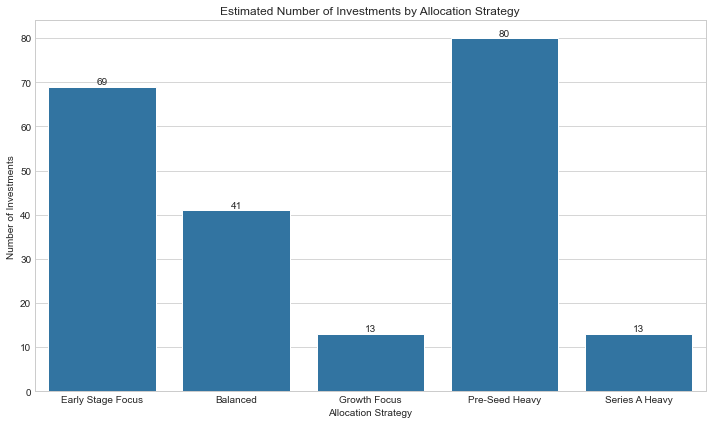


Detailed Investments per Stage:
Stage              Pre-Seed  Seed  Series A  Series B  Total
Scenario                                                    
Balanced               20.0  14.3       3.3       3.3   40.9
Early Stage Focus      40.0  28.6       0.0       0.0   68.6
Growth Focus            0.0   0.0       6.7       6.7   13.4
Pre-Seed Heavy         80.0   0.0       0.0       0.0   80.0
Series A Heavy          0.0   0.0      13.3       0.0   13.3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')


# Let's create a function to estimate the number of investments based on allocation
def estimate_investments(allocation_scenario):
    # Using the check sizes from the original model
    check_sizes = {
        'Pre-Seed': (1.0, 1.5),
        'Seed': (1.5, 2.0),
        'Series A': (5.0, 10.0),
        'Series B': (5, 10)
    }

    # Fund size from original model
    fund_size = 100  # $MM committed

    # Calculate average check size for each stage
    avg_check_sizes = {stage: sum(size_range) / 2 for stage, size_range in check_sizes.items()}

    # For each scenario, calculate estimated number of investments
    results = []

    for scenario_name, allocations in allocation_scenario.items():
        total_allocation = sum(allocations.values())
        # Normalize allocations if needed
        normalized_allocations = {k: v / total_allocation * 100 for k, v in allocations.items()}

        # Calculate deployable capital per stage
        capital_per_stage = {stage: fund_size * alloc / 100 for stage, alloc in normalized_allocations.items()}

        # Estimate number of investments per stage
        investments_per_stage = {stage: capital / avg_check_sizes[stage]
                                 for stage, capital in capital_per_stage.items() if capital > 0}

        # Total estimated investments
        total_investments = sum(investments_per_stage.values())

        results.append({
            'Scenario': scenario_name,
            'Estimated Investments': round(total_investments),
            'Allocations': normalized_allocations,
            'Investments per Stage': investments_per_stage
        })

    return pd.DataFrame(results)


# Define different allocation scenarios
allocation_scenarios = {
    'Early Stage Focus': {'Pre-Seed': 50, 'Seed': 50, 'Series A': 0, 'Series B': 0},
    'Balanced': {'Pre-Seed': 25, 'Seed': 25, 'Series A': 25, 'Series B': 25},
    'Growth Focus': {'Pre-Seed': 0, 'Seed': 0, 'Series A': 50, 'Series B': 50},
    'Pre-Seed Heavy': {'Pre-Seed': 100, 'Seed': 0, 'Series A': 0, 'Series B': 0},
    'Series A Heavy': {'Pre-Seed': 0, 'Seed': 0, 'Series A': 100, 'Series B': 0}
}

# Calculate results
results = estimate_investments(allocation_scenarios)

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
sns.barplot(x='Scenario', y='Estimated Investments', data=results, ax=ax)
ax.set_title('Estimated Number of Investments by Allocation Strategy')
ax.set_ylabel('Number of Investments')
ax.set_xlabel('Allocation Strategy')

# Add value labels to bars
for i, v in enumerate(results['Estimated Investments']):
    ax.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

# Create a detailed table showing investments per stage
detailed_results = []
for _, row in results.iterrows():
    scenario = row['Scenario']
    for stage, num_inv in row['Investments per Stage'].items():
        detailed_results.append({
            'Scenario': scenario,
            'Stage': stage,
            'Investments': round(num_inv, 1)
        })

detailed_df = pd.DataFrame(detailed_results)
detailed_pivot = detailed_df.pivot(index='Scenario', columns='Stage', values='Investments')
detailed_pivot.fillna(0, inplace=True)

# Add total column
detailed_pivot['Total'] = detailed_pivot.sum(axis=1)

print("\nDetailed Investments per Stage:")
print(detailed_pivot.round(1))

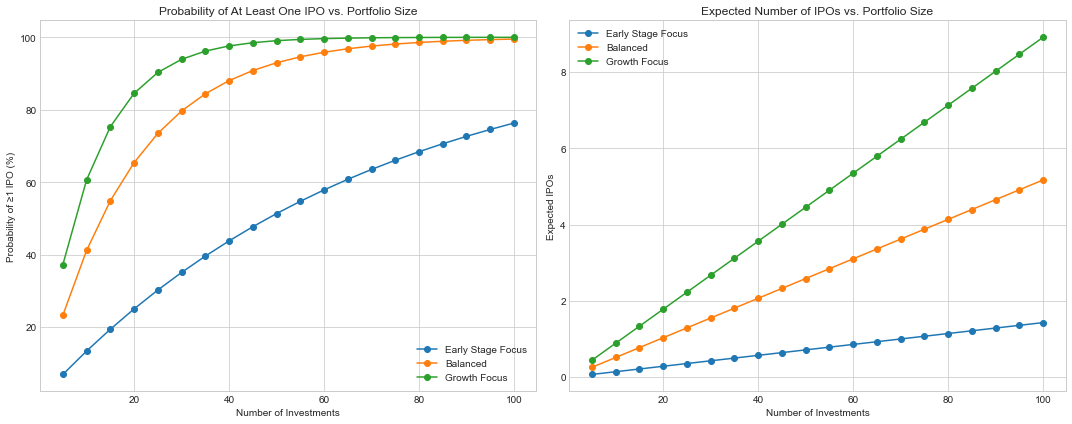

Minimum Portfolio Size Needed to Achieve Probability Threshold:
Probability Threshold (%)  50  75   90   95   99
Stage Mix                                       
Balanced                   14  27   44   57   87
Early Stage Focus          49  97  160  208  320
Growth Focus                8  15   25   33   50


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')

# Core constants from the original model
transition_probs = {
    'Pre-Seed': {'advancement': 0.50, 'failure': 0.30, 'exit': 0.20},
    'Seed': {'advancement': 0.33, 'failure': 0.30, 'exit': 0.37},
    'Series A': {'advancement': 0.48, 'failure': 0.30, 'exit': 0.22},
    'Series B': {'advancement': 0.43, 'failure': 0.20, 'exit': 0.37},
    'Series C': {'advancement': 0.28, 'failure': 0.20, 'exit': 0.52}
}


# Function to calculate probability of reaching IPO from any starting stage
def calc_ipo_probability(start_stage):
    if start_stage == 'IPO':
        return 1.0
    if start_stage not in transition_probs:
        return 0.0

    probs = transition_probs[start_stage]
    next_stage = {'Pre-Seed': 'Seed',
                  'Seed': 'Series A',
                  'Series A': 'Series B',
                  'Series B': 'Series C',
                  'Series C': 'IPO'}

    if start_stage in next_stage:
        return probs['advancement'] * calc_ipo_probability(next_stage[start_stage])
    return 0.0


# Calculate IPO probabilities for each stage
ipo_prob_by_stage = {stage: calc_ipo_probability(stage) for stage in
                     ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C']}


# Function to calculate probability of at least one IPO with n investments
def prob_at_least_one_ipo(num_investments, stage_mix):
    # Calculate weighted average IPO probability based on stage mix
    weighted_prob = sum(ipo_prob_by_stage[stage] * alloc for stage, alloc in stage_mix.items())

    # Probability of no IPOs
    prob_no_ipo = (1 - weighted_prob) ** num_investments

    # Probability of at least one IPO
    return 1 - prob_no_ipo


# Function to calculate expected number of IPOs
def expected_ipos(num_investments, stage_mix):
    weighted_prob = sum(ipo_prob_by_stage[stage] * alloc for stage, alloc in stage_mix.items())
    return num_investments * weighted_prob


# Define different portfolio sizes to test
portfolio_sizes = list(range(5, 101, 5))

# Define different stage mixes
stage_mixes = {
    'Early Stage Focus': {'Pre-Seed': 0.5, 'Seed': 0.5, 'Series A': 0, 'Series B': 0, 'Series C': 0},
    'Balanced': {'Pre-Seed': 0.25, 'Seed': 0.25, 'Series A': 0.25, 'Series B': 0.25, 'Series C': 0},
    'Growth Focus': {'Pre-Seed': 0, 'Seed': 0, 'Series A': 0.5, 'Series B': 0.5, 'Series C': 0}
}

# Calculate probability of at least one IPO for each portfolio size and stage mix
results = []
for mix_name, mix in stage_mixes.items():
    for size in portfolio_sizes:
        prob = prob_at_least_one_ipo(size, mix)
        exp_ipos = expected_ipos(size, mix)
        results.append({
            'Stage Mix': mix_name,
            'Portfolio Size': size,
            'Probability of ≥1 IPO (%)': prob * 100,
            'Expected IPOs': exp_ipos
        })

results_df = pd.DataFrame(results)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='white')

# Plot 1: Probability of at least one IPO
for mix_name in stage_mixes.keys():
    mix_data = results_df[results_df['Stage Mix'] == mix_name]
    ax1.plot(mix_data['Portfolio Size'], mix_data['Probability of ≥1 IPO (%)'],
             marker='o', label=mix_name)

ax1.set_title('Probability of At Least One IPO vs. Portfolio Size')
ax1.set_xlabel('Number of Investments')
ax1.set_ylabel('Probability of ≥1 IPO (%)')
ax1.grid(True)
ax1.legend()

# Plot 2: Expected number of IPOs
for mix_name in stage_mixes.keys():
    mix_data = results_df[results_df['Stage Mix'] == mix_name]
    ax2.plot(mix_data['Portfolio Size'], mix_data['Expected IPOs'],
             marker='o', label=mix_name)

ax2.set_title('Expected Number of IPOs vs. Portfolio Size')
ax2.set_xlabel('Number of Investments')
ax2.set_ylabel('Expected IPOs')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate the minimum portfolio size needed for different probability thresholds
probability_thresholds = [50, 75, 90, 95, 99]
min_size_results = []

for mix_name, mix in stage_mixes.items():
    for threshold in probability_thresholds:
        # Calculate the required portfolio size mathematically
        weighted_prob = sum(ipo_prob_by_stage[stage] * alloc for stage, alloc in mix.items())
        # Formula: 1 - (1-p)^n ≥ threshold/100
        # Solving for n: n ≥ log(1-threshold/100) / log(1-p)
        if weighted_prob > 0:
            min_size = math.ceil(math.log(1 - threshold / 100) / math.log(1 - weighted_prob))
        else:
            min_size = float('inf')

        min_size_results.append({
            'Stage Mix': mix_name,
            'Probability Threshold (%)': threshold,
            'Minimum Portfolio Size': min_size
        })

min_size_df = pd.DataFrame(min_size_results)
min_size_pivot = min_size_df.pivot(index='Stage Mix',
                                   columns='Probability Threshold (%)',
                                   values='Minimum Portfolio Size')

print("Minimum Portfolio Size Needed to Achieve Probability Threshold:")
print(min_size_pivot)

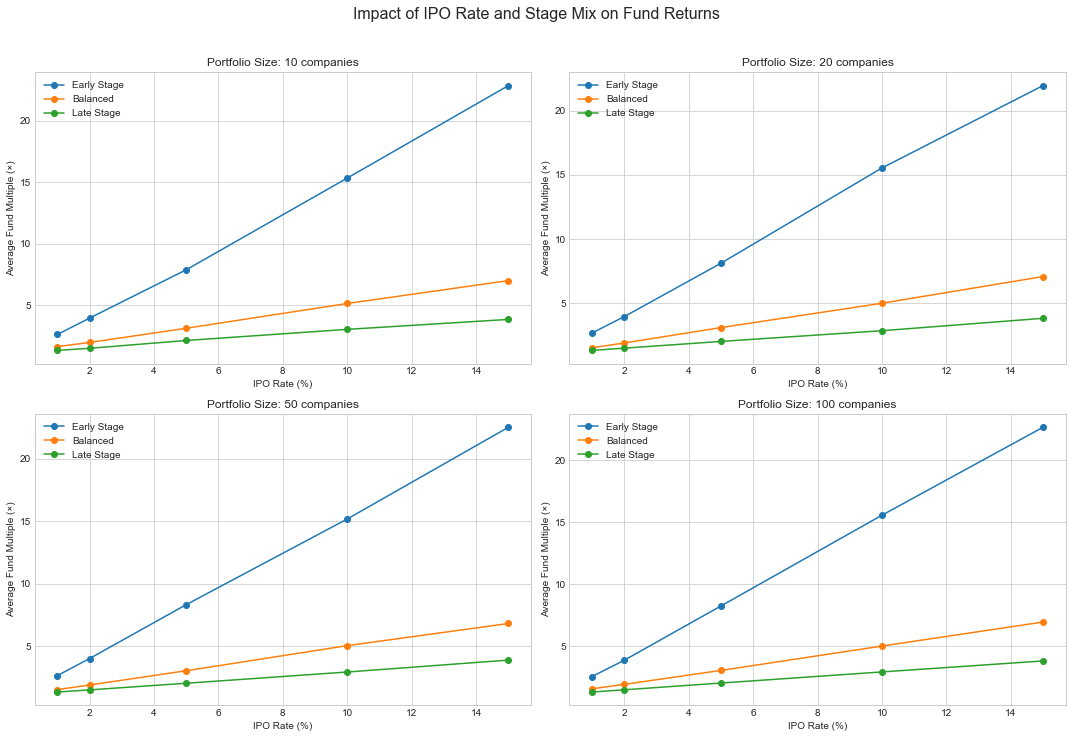

Average Fund Multiple by IPO Rate, Stage Mix, and Portfolio Size:

IPO Rate                    0.01  0.02  0.05   0.10   0.15
Stage Mix   Portfolio Size                                
Balanced    10              1.65  1.98  3.14   5.15   7.01
            20              1.55  1.92  3.12   5.01   7.09
            50              1.54  1.91  3.05   5.06   6.83
            100             1.59  1.94  3.07   5.03   6.97
Early Stage 10              2.63  3.96  7.89  15.35  22.86
            20              2.70  3.97  8.12  15.53  21.94
            50              2.66  4.03  8.33  15.18  22.51
            100             2.58  3.89  8.26  15.58  22.67
Late Stage  10              1.34  1.51  2.14   3.05   3.86
            20              1.34  1.52  2.04   2.88   3.84
            50              1.35  1.52  2.05   2.95   3.90
            100             1.32  1.51  2.05   2.95   3.83


In [5]:
# %%  (single Jupyter cell)

# ───────────────────────────────────────────────────────────
# 0. Imports & global style
# ───────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')    # as requested

# ───────────────────────────────────────────────────────────
# 1. Model assumptions
# ───────────────────────────────────────────────────────────
exit_values = {
    "Pre-Seed": (4, 10),    # $MM exit valuation ranges
    "Seed": (5, 10),
    "Series A": (20, 40),
    "Series B": (40, 120),
    "Series C": (200, 500),
    "IPO": (3000, 5000)
}

entry_valuations = {
    "Pre-Seed": (3, 6),     # $MM post-money
    "Seed": (8, 15),
    "Series A": (40, 80),
    "Series B": (100, 150)
}

check_sizes = {
    "Pre-Seed": (1.0, 1.5),  # $MM cheque
    "Seed": (1.5, 2.0),
    "Series A": (5.0, 10.0),
    "Series B": (5, 10)
}

STAGES_ORDER = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "IPO"]
DILUTION_PER_ROUND = 0.20          # 20 % each follow-on
FAILURE_PROB       = 0.30          # outright wipe-out

# ───────────────────────────────────────────────────────────
# 2. Stage-level ownership & exit-multiple table
# ───────────────────────────────────────────────────────────
def analyze_returns_by_stage():
    rows = []
    for stage in ["Pre-Seed", "Seed", "Series A", "Series B"]:
        avg_entry_val = np.mean(entry_valuations[stage])
        avg_check     = np.mean(check_sizes[stage])
        ownership0    = avg_check / avg_entry_val

        exit_dict = {}
        for exit_stage in STAGES_ORDER:
            if STAGES_ORDER.index(exit_stage) < STAGES_ORDER.index(stage):
                exit_dict[f"Exit at {exit_stage}: Return Multiple"] = np.nan
                continue

            rounds_between   = STAGES_ORDER.index(exit_stage) - STAGES_ORDER.index(stage)
            remain_owner_pct = ownership0 * (1 - DILUTION_PER_ROUND) ** rounds_between
            avg_exit_val     = np.mean(exit_values[exit_stage])
            exit_amount      = remain_owner_pct * avg_exit_val
            exit_dict[f"Exit at {exit_stage}: Return Multiple"] = exit_amount / avg_check

        rows.append(
            {
                "Entry Stage": stage,
                "Avg Check Size ($MM)": avg_check,
                "Avg Ownership (%)": ownership0 * 100,
                **exit_dict,
            }
        )

    return pd.DataFrame(rows)


STAGE_RETURNS = (
    analyze_returns_by_stage().set_index("Entry Stage").to_dict("index")
)

# ───────────────────────────────────────────────────────────
# 3. Fast Monte-Carlo engine
# ───────────────────────────────────────────────────────────
def simulate_portfolio_returns_fast(
    num_companies, ipo_rates, stage_mix, num_sims=1_000, rng=None
):
    """
    Parameters
    ----------
    num_companies : int
    ipo_rates     : list[float]  –– per-company IPO probability
    stage_mix     : dict[str, float] –– allocation weights summing to 1
    """
    rng = np.random.default_rng() if rng is None else rng

    # ----- build per-company vectors (stage, check, IPO-vs-next multiples) -----
    stage_keys, allocs = zip(
        *[(s, w) for s, w in stage_mix.items() if w > 0]
    )
    n_invest = (np.array(allocs) * num_companies).round().astype(int)

    company_checks           = []
    company_ret_if_ipo       = []
    company_ret_if_not_ipo   = []

    for stage, n in zip(stage_keys, n_invest):
        # base data
        check      = STAGE_RETURNS[stage]["Avg Check Size ($MM)"]
        ret_ipo    = STAGE_RETURNS[stage]["Exit at IPO: Return Multiple"]

        # “next” exit stage (Series C if we’re at Series B)
        next_stage = (
            "Series C"
            if stage == "Series B"
            else STAGES_ORDER[STAGES_ORDER.index(stage) + 1]
        )
        ret_next = STAGE_RETURNS[stage][f"Exit at {next_stage}: Return Multiple"]

        # repeat per-company
        company_checks.extend([check] * n)
        company_ret_if_ipo.extend([ret_ipo] * n)
        company_ret_if_not_ipo.extend([ret_next] * n)

    company_checks         = np.array(company_checks)
    company_ret_if_ipo     = np.array(company_ret_if_ipo)
    company_ret_if_not_ipo = np.array(company_ret_if_not_ipo)
    total_invested         = company_checks.sum()

    # container for scenario results
    results = []

    for ipo_rate in ipo_rates:
        # vectorised random draws (shape = [num_sims, num_companies])
        ipo_flag   = rng.random((num_sims, company_checks.size)) < ipo_rate
        fail_flag  = rng.random((num_sims, company_checks.size)) < FAILURE_PROB

        # select return multiple for every company in every simulation
        returns = np.where(
            ipo_flag, company_ret_if_ipo, company_ret_if_not_ipo
        )
        returns = np.where(fail_flag, 0.0, returns)

        fund_multiples = (
            (returns * company_checks).sum(axis=1) / total_invested
        )

        results.append(
            {
                "IPO Rate": ipo_rate,
                "Number of Companies": num_companies,
                "Average Fund Multiple": fund_multiples.mean(),
                "Median Fund Multiple": np.median(fund_multiples),
            }
        )

    return pd.DataFrame(results)


# ───────────────────────────────────────────────────────────
# 4. Scenario definitions
# ───────────────────────────────────────────────────────────
portfolio_sizes = [10, 20, 50, 100]
ipo_rates       = [0.01, 0.02, 0.05, 0.10, 0.15]

stage_mixes = {
    "Early Stage": {"Pre-Seed": 0.50, "Seed": 0.50, "Series A": 0,    "Series B": 0   },
    "Balanced"   : {"Pre-Seed": 0.25, "Seed": 0.25, "Series A": 0.25, "Series B": 0.25},
    "Late Stage" : {"Pre-Seed": 0,    "Seed": 0,    "Series A": 0.50, "Series B": 0.50},
}

# ───────────────────────────────────────────────────────────
# 5. Run all simulations
# ───────────────────────────────────────────────────────────
all_results = []
for mix_name, mix in stage_mixes.items():
    for size in portfolio_sizes:
        df = simulate_portfolio_returns_fast(size, ipo_rates, mix)
        df["Stage Mix"]      = mix_name
        df["Portfolio Size"] = size
        all_results.append(df)

simulation_results = pd.concat(all_results, ignore_index=True)

# ───────────────────────────────────────────────────────────
# 6. Plot: Average fund multiple vs IPO rate
# ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor="white")
axs = axs.flatten()

for i, size in enumerate(portfolio_sizes):
    size_data = simulation_results.query("`Portfolio Size` == @size")

    for mix_name in stage_mixes.keys():
        mix_data = size_data.query("`Stage Mix` == @mix_name")
        axs[i].plot(
            mix_data["IPO Rate"] * 100,
            mix_data["Average Fund Multiple"],
            marker="o",
            label=mix_name,
        )

    axs[i].set_title(f"Portfolio Size: {size} companies")
    axs[i].set_xlabel("IPO Rate (%)")
    axs[i].set_ylabel("Average Fund Multiple (×)")
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle(
    "Impact of IPO Rate and Stage Mix on Fund Returns",
    y=1.02,
    fontsize=16,
)
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────
# 7. Summary pivot table
# ───────────────────────────────────────────────────────────
pivot_table = (
    simulation_results.pivot_table(
        index=["Stage Mix", "Portfolio Size"],
        columns="IPO Rate",
        values="Average Fund Multiple",
        aggfunc="mean",
    )
    .round(2)
)

print("Average Fund Multiple by IPO Rate, Stage Mix, and Portfolio Size:\n")
print(pivot_table)

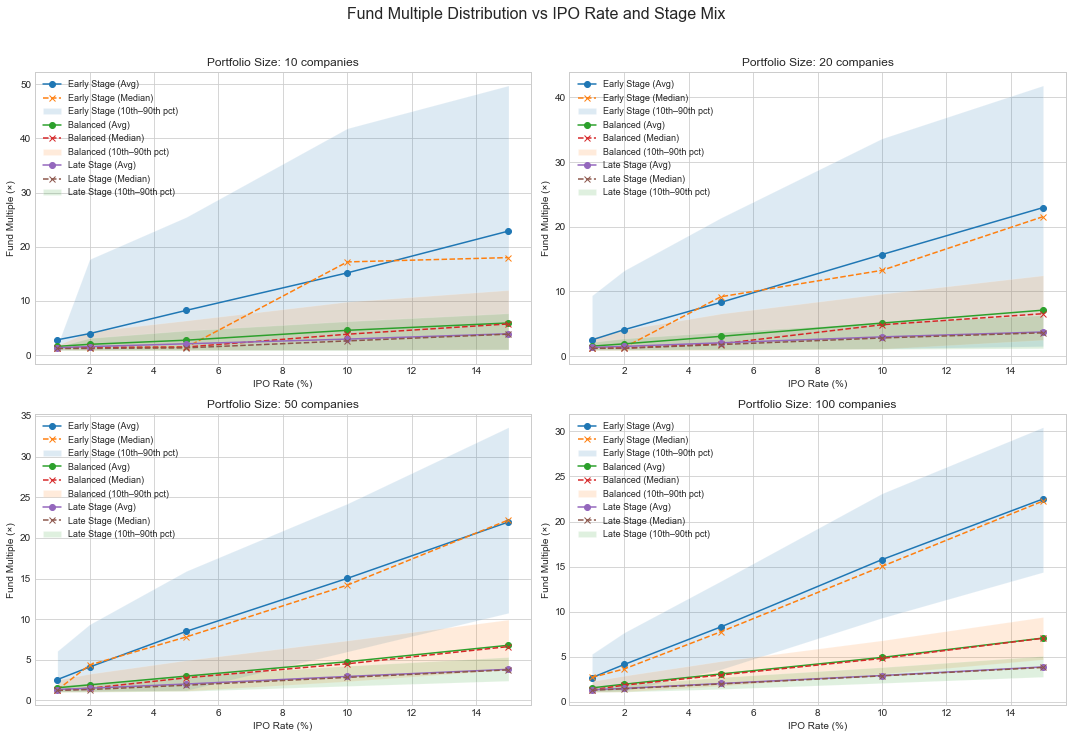

Average Fund Multiple by IPO Rate, Stage Mix, and Portfolio Size:

IPO Rate                    0.01  0.02  0.05   0.10   0.15
Stage Mix   Portfolio Size                                
Balanced    10              1.60  1.98  2.74   4.56   5.92
            20              1.55  1.90  3.06   5.12   7.11
            50              1.56  1.92  2.99   4.76   6.79
            100             1.56  1.96  3.10   4.93   7.08
Early Stage 10              2.81  3.95  8.24  15.17  22.88
            20              2.52  4.09  8.32  15.71  22.97
            50              2.57  4.11  8.50  15.02  21.96
            100             2.69  4.15  8.32  15.78  22.51
Late Stage  10              1.34  1.55  2.07   2.94   3.92
            20              1.35  1.51  2.06   2.98   3.74
            50              1.35  1.51  2.02   2.95   3.83
            100             1.34  1.50  2.04   2.93   3.88


In [14]:
# %%  (single Jupyter cell)

# ───────────────────────────────────────────────────────────
# 0. Imports & global style
# ───────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')  # as requested

# ───────────────────────────────────────────────────────────
# 1. Model assumptions
# ───────────────────────────────────────────────────────────
exit_values = {
    "Pre-Seed": (4, 10),  # $MM exit valuation ranges
    "Seed": (5, 10),
    "Series A": (20, 40),
    "Series B": (40, 120),
    "Series C": (200, 500),
    "IPO": (3000, 5000)
}

entry_valuations = {
    "Pre-Seed": (3, 6),  # $MM post-money
    "Seed": (8, 15),
    "Series A": (40, 80),
    "Series B": (100, 150)
}

check_sizes = {
    "Pre-Seed": (1.0, 1.5),  # $MM cheque
    "Seed": (1.5, 2.0),
    "Series A": (5.0, 10.0),
    "Series B": (5, 10)
}

STAGES_ORDER = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "IPO"]
DILUTION_PER_ROUND = 0.20  # 20 % each follow-on
FAILURE_PROB = 0.30  # outright wipe-out


# ───────────────────────────────────────────────────────────
# 2. Stage-level ownership & exit-multiple table
# ───────────────────────────────────────────────────────────
def analyze_returns_by_stage():
    rows = []
    for stage in ["Pre-Seed", "Seed", "Series A", "Series B"]:
        avg_entry_val = np.mean(entry_valuations[stage])
        avg_check = np.mean(check_sizes[stage])
        ownership0 = avg_check / avg_entry_val

        exit_dict = {}
        for exit_stage in STAGES_ORDER:
            if STAGES_ORDER.index(exit_stage) < STAGES_ORDER.index(stage):
                exit_dict[f"Exit at {exit_stage}: Return Multiple"] = np.nan
                continue

            rounds_between = STAGES_ORDER.index(exit_stage) - STAGES_ORDER.index(stage)
            remain_owner_pct = ownership0 * (1 - DILUTION_PER_ROUND) ** rounds_between
            avg_exit_val = np.mean(exit_values[exit_stage])
            exit_amount = remain_owner_pct * avg_exit_val
            exit_dict[f"Exit at {exit_stage}: Return Multiple"] = exit_amount / avg_check

        rows.append(
            {
                "Entry Stage": stage,
                "Avg Check Size ($MM)": avg_check,
                "Avg Ownership (%)": ownership0 * 100,
                **exit_dict,
            }
        )

    return pd.DataFrame(rows)


STAGE_RETURNS = (
    analyze_returns_by_stage().set_index("Entry Stage").to_dict("index")
)


# ───────────────────────────────────────────────────────────
# 3. Fast Monte-Carlo engine (ENHANCED)
# ───────────────────────────────────────────────────────────
def simulate_portfolio_returns_fast(
        num_companies, ipo_rates, stage_mix, num_sims=1_000, rng=None
):
    """
    Parameters
    ----------
    num_companies : int
    ipo_rates     : list[float]  –– per-company IPO probability
    stage_mix     : dict[str, float] –– allocation weights summing to 1
    """
    rng = np.random.default_rng() if rng is None else rng

    # ----- build per-company vectors (stage, check, IPO-vs-next multiples) -----
    stage_keys, allocs = zip(
        *[(s, w) for s, w in stage_mix.items() if w > 0]
    )
    n_invest = (np.array(allocs) * num_companies).round().astype(int)
    # Adjust last stage to ensure total matches num_companies
    n_invest[-1] += num_companies - n_invest.sum()

    company_checks = []
    company_ret_if_ipo = []
    company_ret_if_not_ipo = []

    for stage, n in zip(stage_keys, n_invest):
        # base data
        check = STAGE_RETURNS[stage]["Avg Check Size ($MM)"]
        ret_ipo = STAGE_RETURNS[stage]["Exit at IPO: Return Multiple"]

        # “next” exit stage (Series C if we’re at Series B)
        next_stage = (
            "Series C"
            if stage == "Series B"
            else STAGES_ORDER[STAGES_ORDER.index(stage) + 1]
        )
        ret_next = STAGE_RETURNS[stage][f"Exit at {next_stage}: Return Multiple"]

        # repeat per-company
        company_checks.extend([check] * n)
        company_ret_if_ipo.extend([ret_ipo] * n)
        company_ret_if_not_ipo.extend([ret_next] * n)

    company_checks = np.array(company_checks)
    company_ret_if_ipo = np.array(company_ret_if_ipo)
    company_ret_if_not_ipo = np.array(company_ret_if_not_ipo)
    total_invested = company_checks.sum()

    # container for scenario results
    results = []

    for ipo_rate in ipo_rates:
        # vectorised random draws (shape = [num_sims, company_checks.size])
        ipo_flag = rng.random((num_sims, company_checks.size)) < ipo_rate
        fail_flag = rng.random((num_sims, company_checks.size)) < FAILURE_PROB

        # select return multiple for every company in every simulation
        returns = np.where(
            ipo_flag, company_ret_if_ipo, company_ret_if_not_ipo
        )
        returns = np.where(fail_flag, 0.0, returns)

        fund_multiples = (
                (returns * company_checks).sum(axis=1) / total_invested
        )

        results.append(
            {
                "IPO Rate": ipo_rate,
                "Number of Companies": num_companies,
                "Average Fund Multiple": fund_multiples.mean(),
                "Median Fund Multiple": np.median(fund_multiples),
                "10th Percentile": np.percentile(fund_multiples, 10),
                "90th Percentile": np.percentile(fund_multiples, 90),
                "Fund Multiples": fund_multiples,  # <-- NEW: store full array
            }
        )

    return pd.DataFrame(results)


# ───────────────────────────────────────────────────────────
# 4. Scenario definitions
# ───────────────────────────────────────────────────────────
portfolio_sizes = [10, 20, 50, 100]
ipo_rates = [0.01, 0.02, 0.05, 0.10, 0.15]

stage_mixes = {
    "Early Stage": {"Pre-Seed": 0.50, "Seed": 0.50, "Series A": 0, "Series B": 0},
    "Balanced": {"Pre-Seed": 0.25, "Seed": 0.25, "Series A": 0.25, "Series B": 0.25},
    "Late Stage": {"Pre-Seed": 0, "Seed": 0, "Series A": 0.50, "Series B": 0.50},
}

# ───────────────────────────────────────────────────────────
# 5. Run all simulations
# ───────────────────────────────────────────────────────────
all_results = []
for mix_name, mix in stage_mixes.items():
    for size in portfolio_sizes:
        df = simulate_portfolio_returns_fast(size, ipo_rates, mix)
        df["Stage Mix"] = mix_name
        df["Portfolio Size"] = size
        all_results.append(df)

simulation_results = pd.concat(all_results, ignore_index=True)

# ───────────────────────────────────────────────────────────
# 6. Enhanced Plot: Fund multiple distribution vs IPO rate
# ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor="white")
axs = axs.flatten()

for i, size in enumerate(portfolio_sizes):
    size_data = simulation_results.query("`Portfolio Size` == @size")

    for mix_name in stage_mixes.keys():
        mix_data = size_data.query("`Stage Mix` == @mix_name")

        # Extract x and y values
        x = mix_data["IPO Rate"] * 100
        avg = mix_data["Average Fund Multiple"]
        med = mix_data["Median Fund Multiple"]
        p10 = mix_data["10th Percentile"]
        p90 = mix_data["90th Percentile"]

        # Plot average (solid), median (dashed), and fill between 10th/90th
        axs[i].plot(x, avg, marker="o", label=f"{mix_name} (Avg)")
        axs[i].plot(x, med, marker="x", linestyle="--", label=f"{mix_name} (Median)")
        axs[i].fill_between(
            x, p10, p90, alpha=0.15, label=f"{mix_name} (10th–90th pct)"
        )

    axs[i].set_title(f"Portfolio Size: {size} companies")
    axs[i].set_xlabel("IPO Rate (%)")
    axs[i].set_ylabel("Fund Multiple (×)")
    axs[i].grid(True)
    axs[i].legend(fontsize=9)

plt.suptitle(
    "Fund Multiple Distribution vs IPO Rate and Stage Mix",
    y=1.02,
    fontsize=16,
)
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────
# 7. Summary pivot table
# ───────────────────────────────────────────────────────────
pivot_table = (
    simulation_results.pivot_table(
        index=["Stage Mix", "Portfolio Size"],
        columns="IPO Rate",
        values="Average Fund Multiple",
        aggfunc="mean",
    )
    .round(2)
)

print("Average Fund Multiple by IPO Rate, Stage Mix, and Portfolio Size:\n")
print(pivot_table)

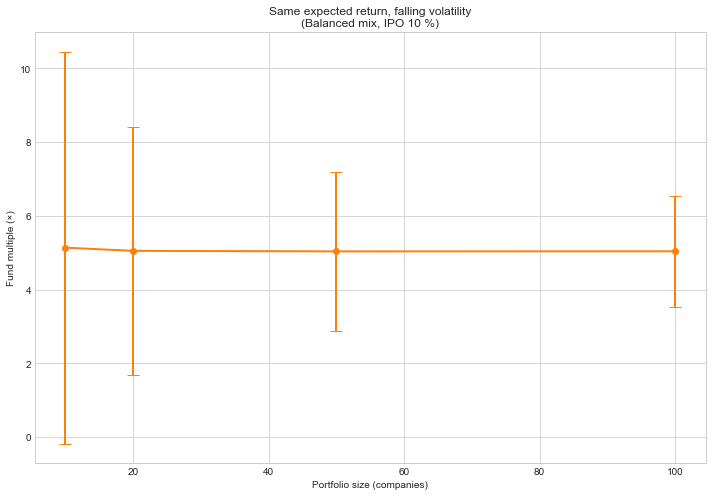

 Portfolio Size  Mean Multiple (×)  Std Dev (×)
             10               5.14         5.32
             20               5.05         3.37
             50               5.04         2.16
            100               5.04         1.50


In [16]:
# %%  Same-mean, falling-σ visual  (Balanced mix, IPO rate = 10 %)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────
# 1. Model assumptions
# ───────────────────────────────────────────────────────────
exit_values = {
    "Pre-Seed":  (4,   10),
    "Seed":      (5,   10),
    "Series A":  (20,  40),
    "Series B":  (40,  120),
    "Series C":  (200, 500),
    "IPO":       (3000, 5000),
}
entry_valuations = {
    "Pre-Seed": (3, 6),
    "Seed":     (8, 15),
    "Series A": (40, 80),
    "Series B": (100, 150),
}
check_sizes = {
    "Pre-Seed": (1.0, 1.5),
    "Seed":     (1.5, 2.0),
    "Series A": (5.0, 10.0),
    "Series B": (5.0, 10.0),
}

STAGES_ORDER        = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "IPO"]
DILUTION_PER_ROUND  = 0.20      # 20 % per follow-on
FAILURE_PROB        = 0.30      # outright write-off

plt.style.use("seaborn-v0_8-whitegrid")   # uniform styling

# ───────────────────────────────────────────────────────────
# 2. Stage-level ownership & exit-multiple table
# ───────────────────────────────────────────────────────────
def analyze_returns_by_stage() -> pd.DataFrame:
    rows = []
    for stage in ["Pre-Seed", "Seed", "Series A", "Series B"]:
        avg_entry_val  = np.mean(entry_valuations[stage])
        avg_check      = np.mean(check_sizes[stage])
        ownership0     = avg_check / avg_entry_val

        exit_dict = {}
        for exit_stage in STAGES_ORDER:
            if STAGES_ORDER.index(exit_stage) < STAGES_ORDER.index(stage):
                exit_dict[f"Exit at {exit_stage}: Return Multiple"] = np.nan
                continue

            rounds_between   = STAGES_ORDER.index(exit_stage) - STAGES_ORDER.index(stage)
            remain_owner_pct = ownership0 * (1 - DILUTION_PER_ROUND) ** rounds_between
            avg_exit_val     = np.mean(exit_values[exit_stage])
            exit_amount      = remain_owner_pct * avg_exit_val
            exit_dict[f"Exit at {exit_stage}: Return Multiple"] = exit_amount / avg_check

        rows.append(
            {
                "Entry Stage": stage,
                "Avg Check Size ($MM)": avg_check,
                "Avg Ownership (%)": ownership0 * 100,
                **exit_dict,
            }
        )
    return pd.DataFrame(rows)

STAGE_RETURNS = analyze_returns_by_stage().set_index("Entry Stage").to_dict("index")

# ───────────────────────────────────────────────────────────
# 3. Vectorised Monte-Carlo (Balanced mix, IPO rate = 10 %)
# ───────────────────────────────────────────────────────────
# OPTION A – keep typing, compatible back to 3.6
from typing import Optional

def simulate_one_scenario(portfolio_size: int,
                          ipo_rate: float = 0.10,
                          stage_mix: Optional[dict] = None,
                          num_sims: int = 20_000,
                          rng: Optional[np.random.Generator] = None):

    """Return mean and stdev of fund multiple for one (size, ipo_rate, mix) triad."""
    if stage_mix is None:
        stage_mix = {"Pre-Seed": .25, "Seed": .25, "Series A": .25, "Series B": .25}
    rng = np.random.default_rng() if rng is None else rng

    stage_keys, allocs = zip(*[(s, w) for s, w in stage_mix.items() if w > 0])
    n_invest = (np.array(allocs) * portfolio_size).round().astype(int)

    checks             = []
    ret_if_ipo         = []
    ret_if_not_ipo     = []

    for stage, n in zip(stage_keys, n_invest):
        check  = STAGE_RETURNS[stage]["Avg Check Size ($MM)"]
        r_ipo  = STAGE_RETURNS[stage]["Exit at IPO: Return Multiple"]
        next_stage = "Series C" if stage == "Series B" else STAGES_ORDER[STAGES_ORDER.index(stage) + 1]
        r_next = STAGE_RETURNS[stage][f"Exit at {next_stage}: Return Multiple"]

        checks.extend([check] * n)
        ret_if_ipo.extend([r_ipo] * n)
        ret_if_not_ipo.extend([r_next] * n)

    checks         = np.array(checks)
    ret_if_ipo     = np.array(ret_if_ipo)
    ret_if_not_ipo = np.array(ret_if_not_ipo)
    total_invested = checks.sum()

    ipo_flag  = rng.random((num_sims, checks.size)) < ipo_rate
    fail_flag = rng.random((num_sims, checks.size)) < FAILURE_PROB

    returns = np.where(ipo_flag, ret_if_ipo, ret_if_not_ipo)
    returns = np.where(fail_flag, 0.0, returns)

    fund_multiples = (returns * checks).sum(axis=1) / total_invested
    return fund_multiples.mean(), fund_multiples.std()

# Portfolios to test
portfolio_sizes = [10, 20, 50, 100]
means, stds = zip(*(simulate_one_scenario(s) for s in portfolio_sizes))

# ───────────────────────────────────────────────────────────
# 4. Plot mean ± 1 σ error bars
# ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
ax.errorbar(portfolio_sizes, means, yerr=stds,
            fmt="o-", capsize=6, linewidth=2, color="tab:orange")
ax.set_xlabel("Portfolio size (companies)")
ax.set_ylabel("Fund multiple (×)")
ax.set_title("Same expected return, falling volatility\n(Balanced mix, IPO 10 %)")
ax.grid(True)
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────
# 5. Numeric punch-line table
# ───────────────────────────────────────────────────────────
dispersion = pd.DataFrame({
    "Portfolio Size": portfolio_sizes,
    "Mean Multiple (×)": np.round(means, 2),
    "Std Dev (×)": np.round(stds, 2),
})
print(dispersion.to_string(index=False))